In [10]:
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold
from scipy.optimize import minimize
from sklearn.metrics import r2_score
import pickle

In [14]:
# Load the data
raw_Data= pd.read_excel('v4_BMED_data.xlsx',sheet_name="Opt2")
display(raw_Data)

,T,V,E,Ci,t2,CF,CA,SEC,JLA
0,35.4,35,0.50,3.247751,2.000000,2.666598,0.272588,9.960608,223.608106
1,22.7,30,0.25,2.223349,0.500000,3.363995,0.001075,7.558347,22.050678
2,31.8,35,0.50,3.247751,2.933333,2.470914,0.577139,7.339164,543.993190
3,22.3,30,0.25,2.622149,3.000000,1.787875,0.097067,7.239258,47.522121
4,19.1,30,0.25,0.978717,3.000000,0.866674,0.007030,6.429151,6.259306
...,...,...,...,...,...,...,...,...,...
209,31.0,35,0.50,3.177672,1.000000,2.832331,0.042870,0.235720,280.759175
210,20.6,10,0.25,2.849646,4.000000,2.172786,0.409563,0.187888,84.909708
211,21.0,10,0.25,2.849646,2.000000,2.293890,0.260849,0.115255,167.303571
212,21.8,10,0.25,2.849646,1.000000,2.337014,0.138304,0.074761,222.257364


In [15]:
# Data Set
Xg = raw_Data[['T','V','E','Ci','t2','CF','CA']].values
Yg = raw_Data[['SEC','JLA']].values

T, V, E, Ci, t2, CF, CA = [i[0] for i in Xg], [i[1] for i in Xg], [i[2] for i in Xg], [i[3] for i in Xg], [i[4] for i in Xg], [i[5] for i in Xg], [i[6] for i in Xg]
SEC, JLA = [i[0] for i in Yg], [i[1] for i in Yg]

# min-max normalization
mXg = list(range(len(Xg)))
mYg = list(range(len(Yg)))

for i in range(len(mXg)):
    iX = [(T[i]-np.min(T))/(np.max(T)-np.min(T)),(V[i]-np.min(V))/(np.max(V)-np.min(V)),(E[i]-np.min(E))/(np.max(E)-np.min(E)),(Ci[i]-np.min(Ci))/(np.max(Ci)-np.min(Ci)),(t2[i]-np.min(t2))/(np.max(t2)-np.min(t2)),(CF[i]-np.min(CF))/(np.max(CF)-np.min(CF)),(CA[i]-np.min(CA))/(np.max(CA)-np.min(CA))]
    iY = [(SEC[i]-np.min(SEC))/(np.max(SEC)-np.min(SEC)),(JLA[i]-np.min(JLA))/(np.max(JLA)-np.min(JLA))]
    mXg[i], mYg[i] = iX, iY
mX, mY = np.asarray(mXg), np.log(np.asarray(mYg)+0.1)

In [16]:
# GP model optimization _ Total Regression
rs_1 = np.arange(0,30,1)
best_r2_1 = -np.inf
best_r2_2 = -np.inf
best_GPR1 = 0
best_GPR2 = 0
for i in range(len(rs_1)):
    X_train, X_test, Y_train, Y_test = train_test_split(mX, mY, test_size=0.3, random_state=rs_1[i])
    # X_train, X_test, Y_train, Y_test = np.asarray(X_train), np.asarray(X_test), np.asarray(Y_train), np.asarray(Y_test)

    rs_2 = np.arange(0,40,1)
    fun1 = []
    alpha1 = []

    for j in range(len(rs_2)):
        alp = [1e-4,1e-4]
        
        # optimize the parameter alpha of gaussian process regressor
        def alpha_GP1_opt(alp1):
            kfold = KFold(n_splits=5, shuffle=True, random_state= rs_2[j])
            mse_scores_1 = []
            for train_index, test_index in kfold.split(X_train):
                X_train2, X_test2 = X_train[train_index], X_train[test_index]
                Y_train2, Y_test2 = Y_train[train_index], Y_train[test_index]

                GPR1 = GaussianProcessRegressor(alpha=alp1)
                GPR1.fit(X_train2, [j[0] for j in Y_train2])
                ypred1 = GPR1.predict(X_test2)

                mse_1 = mse(np.asarray([j[0] for j in Y_test2]),ypred1)
                mse_scores_1.append(mse_1)
            
            return sum(mse_scores_1) / len(mse_scores_1)
        
        res1 = minimize(alpha_GP1_opt,alp[0],bounds=[(1e-10,10)])
        alpha1.append(res1.x)
        fun1.append(res1.fun)

    fun2 = []
    alpha2 = []
    for j in range(len(rs_2)):
        def alpha_GP2_opt(alp2):
            kfold = KFold(n_splits=5, shuffle=True, random_state= rs_2[j])
            mse_scores_2 = []
            for train_index, test_index in kfold.split(X_train):
                X_train2, X_test2 = X_train[train_index], X_train[test_index]
                Y_train2, Y_test2 = Y_train[train_index], Y_train[test_index]

                GPR2 = GaussianProcessRegressor(alpha=alp2)
                GPR2.fit(X_train2, [j[1] for j in Y_train2])
                ypred2 = GPR2.predict(X_test2)

                mse_2 = mse(np.asarray([j[1] for j in Y_test2]),ypred2)
                mse_scores_2.append(mse_2)
            
            return sum(mse_scores_2) / len(mse_scores_2)


        res2 = minimize(alpha_GP2_opt,alp[1],bounds=[(1e-10,10)])
        alpha2.append(res2.x)
        fun2.append(res2.fun)
    fun1 = np.asarray(fun1)
    fun2 = np.asarray(fun2)
    fun_min1 = np.argmin(fun1)
    fun_min2 = np.argmin(fun2)
    alp1_opt = alpha1[fun_min1]
    alp2_opt =  alpha2[fun_min2] 

    GPR1f = GaussianProcessRegressor(alpha=alp1_opt)
    GPR1f.fit(X_train, [i[0] for i in Y_train])
    ypred1,_ = GPR1f.predict(mX,[i[0] for i in mY])

    GPR2f = GaussianProcessRegressor(alpha=alp2_opt)
    GPR2f.fit(X_train, [i[1] for i in Y_train])
    ypred2,_ = GPR2f.predict(mX,[i[1] for i in mY])

    r2_1 = r2_score([i[0] for i in mY],ypred1)
    r2_2 = r2_score([i[1] for i in mY],ypred2)

    if best_r2_1 < r2_1:
        best_r2_1 = r2_1
        best_GPR1 = GPR1f
        print(f'GPR1 update! R1 = {r2_1}')
    if best_r2_2 < r2_2:
        best_r2_2 = r2_2
        best_GPR2 = GPR2f
        print(f'GPR2 update! R2 = {r2_2}')
    print(f'Iteration:{i}/{len(rs_1)-1}')
print("fin")



GPR1 update! R1 = 0.6237416935297653
GPR2 update! R2 = 0.9230366374353467
Iteration:0/29
Iteration:1/29
GPR1 update! R1 = 0.6718531294595627
Iteration:2/29
Iteration:3/29
GPR2 update! R2 = 0.9258696634837164
Iteration:4/29
Iteration:5/29
Iteration:6/29
Iteration:7/29
GPR1 update! R1 = 0.6780186461982834
Iteration:8/29
Iteration:9/29
GPR1 update! R1 = 0.7233431257293743
Iteration:10/29
Iteration:11/29
Iteration:12/29
Iteration:13/29
Iteration:14/29
Iteration:15/29
Iteration:16/29
Iteration:17/29
GPR2 update! R2 = 0.9263972942834954
Iteration:18/29
Iteration:19/29
Iteration:20/29
Iteration:21/29
Iteration:22/29
Iteration:23/29
Iteration:24/29
Iteration:25/29
Iteration:26/29
Iteration:27/29
Iteration:28/29
Iteration:29/29
fin


In [5]:
# # GP model optimization _ Total Regression
# rs_1 = np.arange(0,200,1)
# best_r2_1 = -np.inf
# best_r2_2 = -np.inf
# best_GPR1 = 0
# best_GPR2 = 0
# for i in range(len(rs_1)):
#     X_train, X_test, Y_train, Y_test = train_test_split(mX, mY, test_size=0.2, random_state=rs_1[i])
#     # X_train, X_test, Y_train, Y_test = np.asarray(X_train), np.asarray(X_test), np.asarray(Y_train), np.asarray(Y_test)
#     kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
#     xt1 = np.array(X_train)
#     yt1 = np.array([i[0] for i in Y_train])
#     GPR1 = GPy.models.GPRegression(xt1,yt1,kernel)
#     GPR1.optimize()
#     ypred1,_ = GPR1.predict(mX,[i[0] for i in mY])

#     yt2 = np.array([i[1] for i in Y_train])
#     GPR2 = GPy.models.GPRegression(xt1,yt2,kernel)
#     GPR2.optimize()
#     ypred2,_ = GPR2.predict(mX,[i[1] for i in mY])

#     r2_1 = r2_score([i[0] for i in mY],ypred1)
#     r2_2 = r2_score([i[1] for i in mY],ypred2)

#     if best_r2_1 < r2_1:
#         best_r2_1 = r2_1
#         best_GPR1 = GPR1
#         print(f'GPR1 update! R2 = {r2_1}')
#     if best_r2_2 < r2_2:
#         best_r2_2 = r2_2
#         best_GPR2 = GPR2
#         print(f'GPR2 update! R2 = {r2_2}')
#     print(f'Iteration:{i}/{200}')




r2_1:0.7233431257293743, r2_2:0.9263972942834954


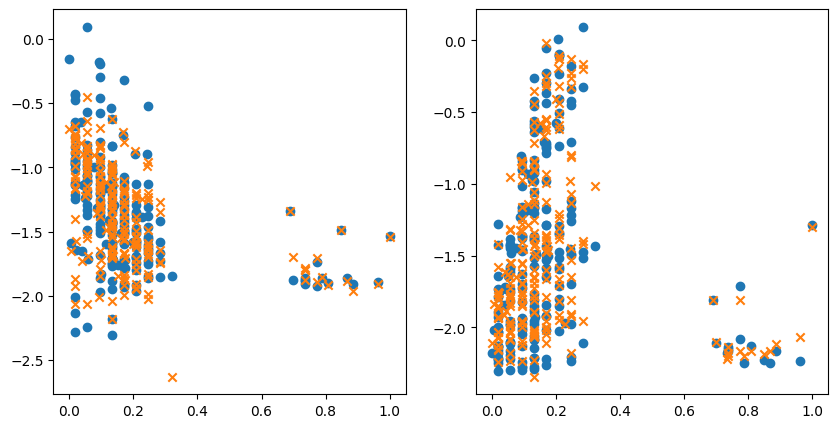

In [17]:
yt1,_ = best_GPR1.predict(mX,[i[0] for i in mY])
yt2,_ = best_GPR2.predict(mX,[i[1] for i in mY])

fig, axs = plt.subplots(1,2, figsize =(10,5))

axs[0].scatter([i[4] for i in mX],[i[0] for i in mY],marker='o')
axs[0].scatter([i[4] for i in mX],yt1,marker='x')

axs[1].scatter([i[4] for i in mX],[i[1] for i in mY],marker='o')
axs[1].scatter([i[4] for i in mX],yt2,marker='x')

r2_1 = r2_score([i[0] for i in mY],yt1)
r2_2 = r2_score([i[1] for i in mY],yt2)
print(f'r2_1:{r2_1}, r2_2:{r2_2}')

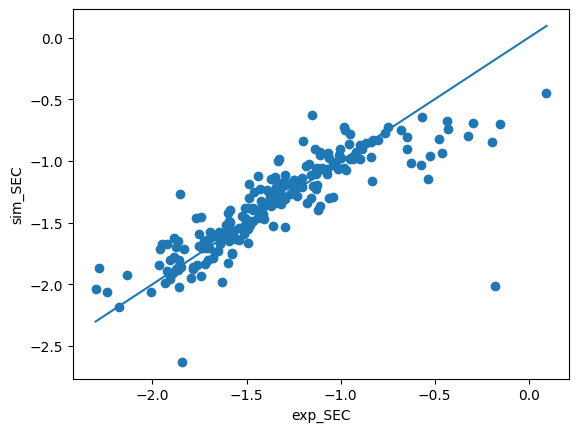

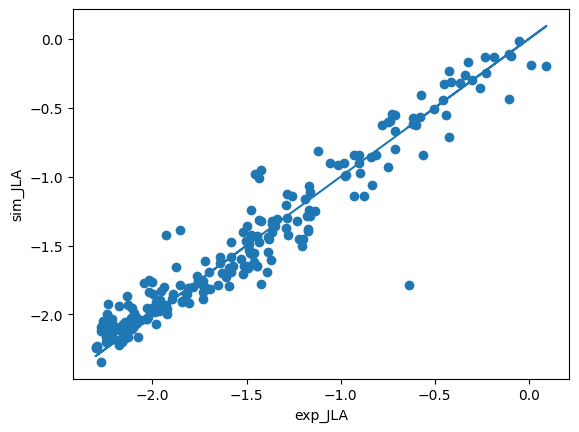

0.9263972942834954

In [22]:
Y_SEC = [i[0] for i in mY]
y_SEC = yt1

Y_JLA = [i[1] for i in mY]
y_JLA = yt2

plt.scatter(Y_SEC,y_SEC)
plt.plot(Y_SEC,Y_SEC)
plt.xlabel('exp_SEC')
plt.ylabel('sim_SEC')
plt.show()
r2_score(Y_SEC,y_SEC)

plt.scatter(Y_JLA,y_JLA)
plt.plot(Y_JLA,Y_JLA)
plt.xlabel('exp_JLA')
plt.ylabel('sim_JLA')
plt.show()
r2_score(Y_JLA,y_JLA)

In [19]:
with open('GPR1.pkl', 'wb') as model_file:
    pickle.dump(best_GPR1, model_file)

with open('GPR2.pkl', 'wb') as model_file:
    pickle.dump(best_GPR2, model_file)



In [8]:
# 저장된 모델 불러오기
with open('gpr_model.pkl', 'rb') as model_file:
    loaded_gpr = pickle.load(model_file)

FileNotFoundError: [Errno 2] No such file or directory: 'gpr_model.pkl'

In [26]:
# Data Set
Xg = raw_Data[['Ci','CF','CA']].values
Yg = raw_Data[['SEC','JLA']].values

Ci, CF, CA = [i[0] for i in Xg], [i[1] for i in Xg], [i[2] for i in Xg]
SEC, JLA = [i[0] for i in Yg], [i[1] for i in Yg]

# min-max normalization
mXg = list(range(len(Xg)))
mYg = list(range(len(Yg)))

for i in range(len(mXg)):
    iX = [(Ci[i]-np.min(Ci))/(np.max(Ci)-np.min(Ci)),(CF[i]-np.min(CF))/(np.max(CF)-np.min(CF)),(CA[i]-np.min(CA))/(np.max(CA)-np.min(CA))]
    iY = [(SEC[i]-np.min(SEC))/(np.max(SEC)-np.min(SEC)),(JLA[i]-np.min(JLA))/(np.max(JLA)-np.min(JLA))]
    mXg[i], mYg[i] = iX, iY
mX, mY = np.asarray(mXg), np.log(np.asarray(mYg)+1e-10)

In [29]:
# GP model optimization _ Total Regression
rs_1 = np.arange(0,100,1)
best_r2_1 = -np.inf
best_r2_2 = -np.inf
best_GPR1 = 0
best_GPR2 = 0
for i in range(len(rs_1)):
    X_train, X_test, Y_train, Y_test = train_test_split(mX, mY, test_size=0.3, random_state=rs_1[i])
    # X_train, X_test, Y_train, Y_test = np.asarray(X_train), np.asarray(X_test), np.asarray(Y_train), np.asarray(Y_test)

    rs_2 = np.arange(0,100,1)
    fun1 = []
    alpha1 = []

    for j in range(len(rs_2)):
        alp = [1e-4,1e-4]
        
        # optimize the parameter alpha of gaussian process regressor
        def alpha_GP1_opt(alp1):
            kfold = KFold(n_splits=5, shuffle=True, random_state= rs_2[j])
            mse_scores_1 = []
            for train_index, test_index in kfold.split(X_train):
                X_train2, X_test2 = X_train[train_index], X_train[test_index]
                Y_train2, Y_test2 = Y_train[train_index], Y_train[test_index]

                GPR1 = GaussianProcessRegressor(alpha=alp1)
                GPR1.fit(X_train2, [j[0] for j in Y_train2])
                ypred1 = GPR1.predict(X_test2)

                mse_1 = mse(np.asarray([j[0] for j in Y_test2]),ypred1)
                mse_scores_1.append(mse_1)
            
            return sum(mse_scores_1) / len(mse_scores_1)
        
        res1 = minimize(alpha_GP1_opt,alp[0],bounds=[(1e-10,10)])
        alpha1.append(res1.x)
        fun1.append(res1.fun)

    fun2 = []
    alpha2 = []
    for j in range(len(rs_2)):
        def alpha_GP2_opt(alp2):
            kfold = KFold(n_splits=5, shuffle=True, random_state= rs_2[j])
            mse_scores_2 = []
            for train_index, test_index in kfold.split(X_train):
                X_train2, X_test2 = X_train[train_index], X_train[test_index]
                Y_train2, Y_test2 = Y_train[train_index], Y_train[test_index]

                GPR2 = GaussianProcessRegressor(alpha=alp2)
                GPR2.fit(X_train2, [j[1] for j in Y_train2])
                ypred2 = GPR2.predict(X_test2)

                mse_2 = mse(np.asarray([j[1] for j in Y_test2]),ypred2)
                mse_scores_2.append(mse_2)
            
            return sum(mse_scores_2) / len(mse_scores_2)


        res2 = minimize(alpha_GP2_opt,alp[1],bounds=[(1e-10,10)])
        alpha2.append(res2.x)
        fun2.append(res2.fun)
    fun1 = np.asarray(fun1)
    fun2 = np.asarray(fun2)
    fun_min1 = np.argmin(fun1)
    fun_min2 = np.argmin(fun2)
    alp1_opt = alpha1[fun_min1]
    alp2_opt =  alpha2[fun_min2] 

    GPR1f = GaussianProcessRegressor(alpha=alp1_opt)
    GPR1f.fit(X_train, [i[0] for i in Y_train])
    ypred1,_ = GPR1f.predict(mX,[i[0] for i in mY])

    GPR2f = GaussianProcessRegressor(alpha=alp2_opt)
    GPR2f.fit(X_train, [i[1] for i in Y_train])
    ypred2,_ = GPR2f.predict(mX,[i[1] for i in mY])

    r2_1 = r2_score([i[0] for i in mY],ypred1)
    r2_2 = r2_score([i[1] for i in mY],ypred2)

    if best_r2_1 < r2_1:
        best_r2_1 = r2_1
        best_GPR1 = GPR1f
        print(f'GPR1 update! R1 = {r2_1}')
    if best_r2_2 < r2_2:
        best_r2_2 = r2_2
        best_GPR2 = GPR2f
        print(f'GPR2 update! R2 = {r2_2}')
    print(f'Iteration:{i}/{200}')




GPR1 update! R1 = 0.1396713369281456
GPR2 update! R2 = 0.4618334757959951
Iteration:0/200
Iteration:1/200
Iteration:2/200
Iteration:3/200
GPR1 update! R1 = 0.19369209563042056
Iteration:4/200
Iteration:5/200
Iteration:6/200
GPR2 update! R2 = 0.4966107819641917
Iteration:7/200
Iteration:8/200
Iteration:9/200
Iteration:10/200
Iteration:11/200
Iteration:12/200
Iteration:13/200
Iteration:14/200
Iteration:15/200
Iteration:16/200
Iteration:17/200
Iteration:18/200
Iteration:19/200
Iteration:20/200
Iteration:21/200
Iteration:22/200
Iteration:23/200
Iteration:24/200
Iteration:25/200
Iteration:26/200
Iteration:27/200
Iteration:28/200
Iteration:29/200
GPR1 update! R1 = 0.19475857438641586
Iteration:30/200
Iteration:31/200
Iteration:32/200
Iteration:33/200
Iteration:34/200
Iteration:35/200
Iteration:36/200
Iteration:37/200
Iteration:38/200
Iteration:39/200
Iteration:40/200
GPR1 update! R1 = 0.19588010032554048
Iteration:41/200
Iteration:42/200
Iteration:43/200
Iteration:44/200
Iteration:45/200
Ite

KeyboardInterrupt: 

In [28]:
with open('GPR1.pkl', 'wb') as model_file:
    pickle.dump(best_GPR1, model_file)

with open('GPR2.pkl', 'wb') as model_file:
    pickle.dump(best_GPR2, model_file)